In [ ]:
!pip install pyspark
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 45 kB/s 
     |████████████████████████████████| 199 kB 44.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=0e957f9a211db3adf7fd70e130381551a61d6062a11cb9a5a48263f6ed7eb0e1
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import findspark
findspark.init()

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from sklearn.metrics import accuracy_score
import datetime
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
df=pd.read_csv('/content/music_genre_dataset.csv')

# Feature Engineering

In [ ]:
df['Artist Name'].nunique()

8287

In [ ]:
df.head(2)

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.0171,NaN,0.0849,0.899,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.0011,0.00401,0.1010,0.569,116.454,251733.0,4,10


In [ ]:
def minutes(duration):
     if(str(duration)[1]!=".") or (str(duration)[2]!="."):
        return (duration/1000)/60
     else:
        return duration

In [ ]:
#Converging Duration Column into Minutes
df['Duration']=df.apply(lambda x: minutes(x['duration_in min/ms']),axis=1)
df.drop(['duration_in min/ms'], axis = 1,inplace=True)

In [ ]:
df['danceability'].median()

0.543

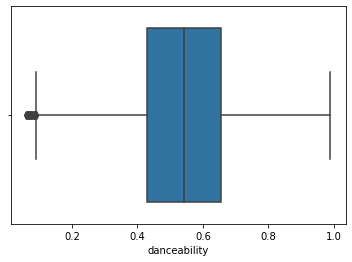

In [ ]:
sns.boxplot(x=df['danceability'],data=df)

In [ ]:
# Creating new column determining danceability of a song
median=df['danceability'].median()
df['Danceable']=pd.DataFrame
for i in range(len(df)):
    if(df['danceability'][i]>=median):
        df['Danceable'][i]=1
    else:
        df['Danceable'][i]=0

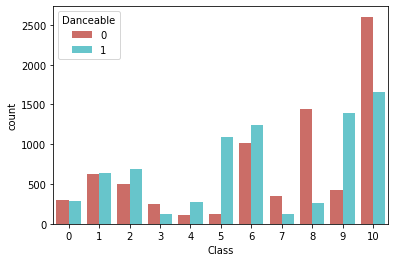

In [ ]:
sns.countplot(x='Class',hue='Danceable',data=df,palette='hls')

## Exploring label column

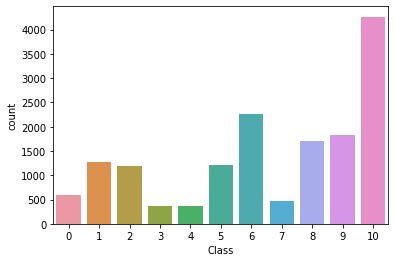

In [ ]:
sns.countplot(x='Class',data=df)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


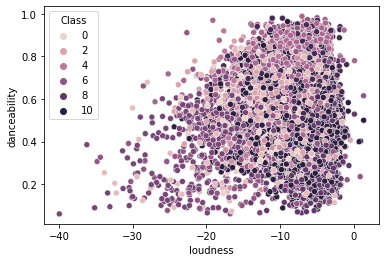

In [ ]:
sns.scatterplot(df['loudness'],y=df.danceability,hue=df.Class,data=df)

In [ ]:
df['Class'].nunique()

11

# Data Cleaning

In [ ]:
# Removing Duplicates in DataFrame
df.drop_duplicates(inplace=True)

In [ ]:
df.info

<bound method DataFrame.info of                                   Artist Name  \
0                                  Bruno Mars   
1                                      Boston   
2                               The Raincoats   
3                                        Deno   
4                       Red Hot Chili Peppers   
...                                       ...   
15512                              Television   
15513                                 Hulkoff   
15514  Red Garland, Paul Chambers, Art Taylor   
15515                                   Squid   
15516                              Bad Wolves   

                                  Track Name  Popularity  danceability  \
0      That's What I Like (feat. Gucci Mane)        60.0         0.854   
1                               Hitch a Ride        54.0         0.382   
2                         No Side to Fall In        35.0         0.434   
3                 Lingo (feat. J.I & Chunkz)        66.0         0.853   
4        

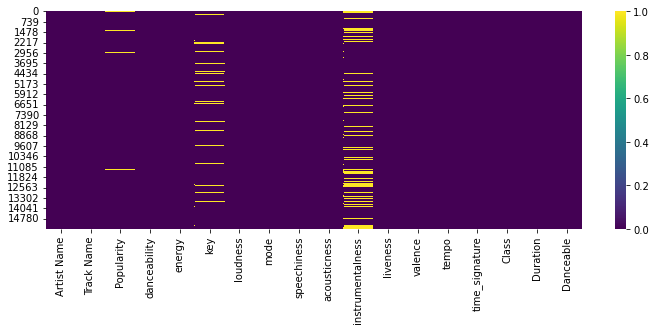

In [ ]:
plt.figure(figsize=(12,4))
sns.heatmap(df.isnull(),cmap='viridis')

(10.0, 0.0)

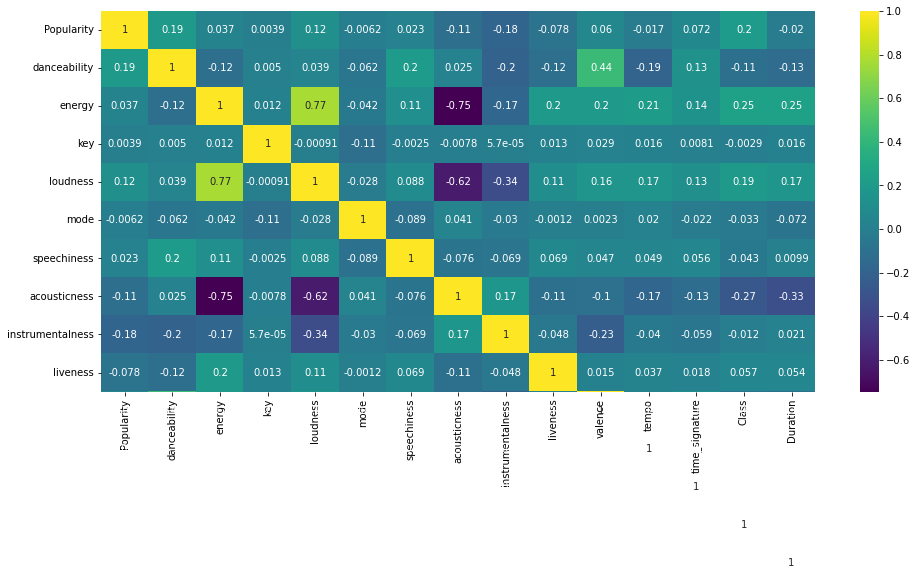

In [ ]:
plt.figure(figsize=(16,7))
sns.heatmap(df.corr(),annot=True,cmap='viridis')
plt.ylim(10, 0)

In [ ]:
100* df.isnull().sum()/len(df)

Artist Name          0.000000
Track Name           0.000000
Popularity           2.539151
danceability         0.000000
energy               0.000000
key                 11.232841
loudness             0.000000
mode                 0.000000
speechiness          0.000000
acousticness         0.000000
instrumentalness    23.116582
liveness             0.000000
valence              0.000000
tempo                0.000000
time_signature       0.000000
Class                0.000000
Duration             0.000000
Danceable            0.000000
dtype: float64

## Filling Popularity Column using forward-filling

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


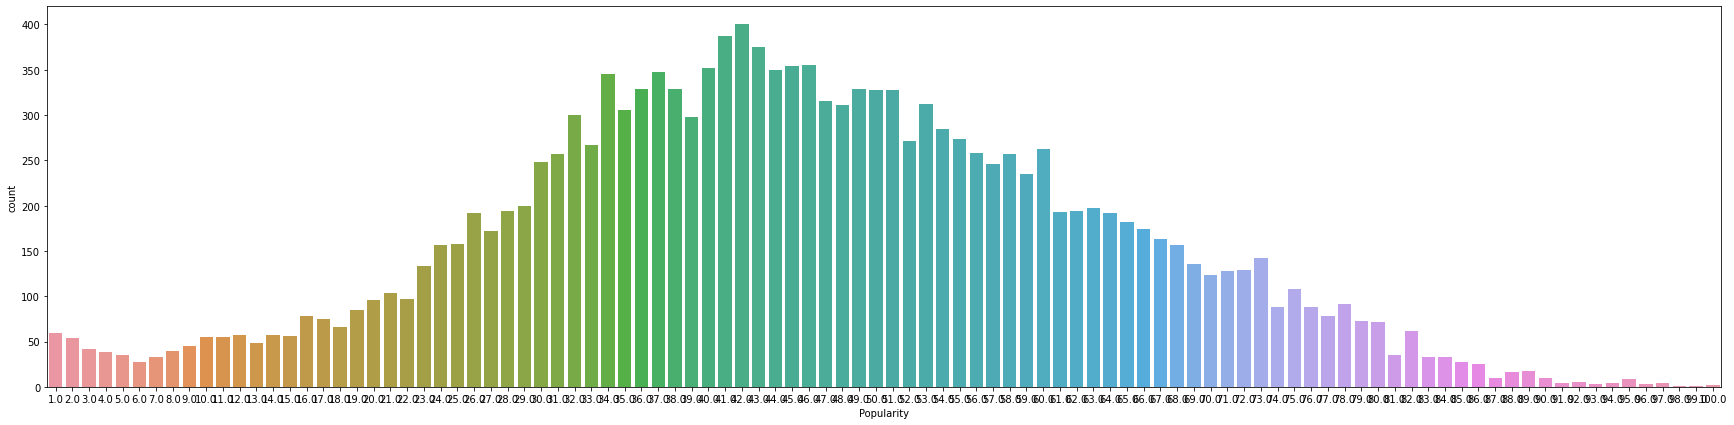

In [ ]:
plt.figure(figsize=(30,7))
sns.countplot(df['Popularity'])

In [ ]:
df['Popularity'].fillna(method='ffill',inplace=True)

## Filling Instrumentalness Column using acousticness Column

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


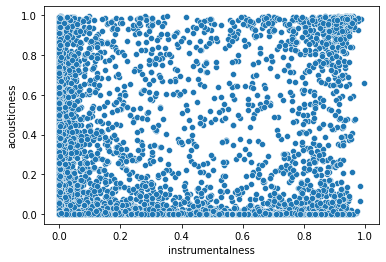

In [ ]:
sns.scatterplot(df.instrumentalness,df['acousticness'])

In [ ]:
c=df.groupby('acousticness').mean()['instrumentalness']
for i in range(len(df['instrumentalness'])):
    if df['instrumentalness'].isnull().iloc[i]:
        x=df['acousticness'].iloc[i]
        check_Null=c[x]
        if check_Null!=check_Null:
            df['instrumentalness'].iloc[i]=df['instrumentalness'].mean()
        else:    
            df['instrumentalness'].iloc[i]=c[x]

## Dealing with key column

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


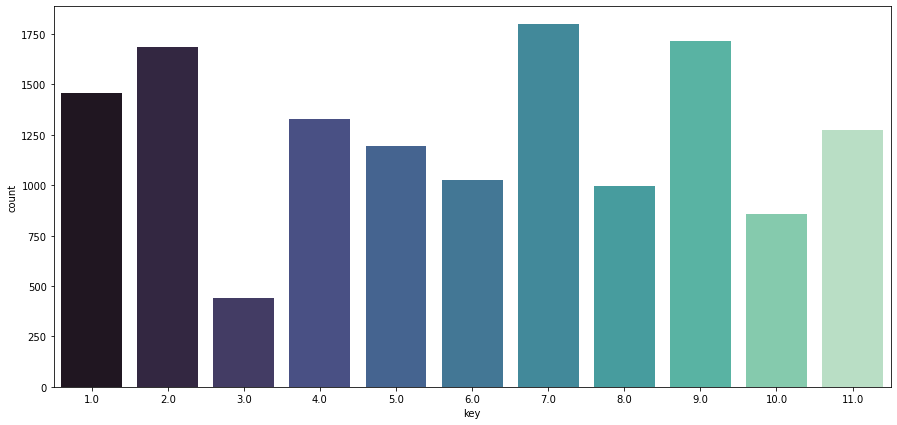

In [ ]:
plt.figure(figsize=(15,7))
sns.countplot(df['key'],palette='mako')

In [ ]:
df.dropna(inplace=True)

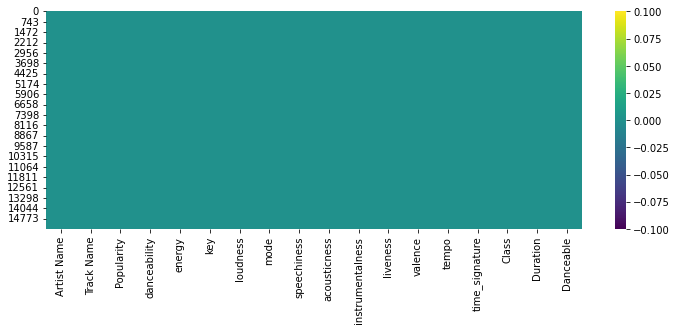

In [ ]:
plt.figure(figsize=(12,4))
sns.heatmap(df.isnull(),cmap='viridis')

# Spark

In [ ]:
# Creating a spark context class
sc = SparkContext()

# Creating a spark session
spark = SparkSession \
    .builder \
    .appName("Python Spark DataFrames basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [ ]:
spark

In [ ]:
# df = pd.read_csv('/content/music_genre_dataset.csv')
sdf = spark.createDataFrame(df) 

In [ ]:
sdf.show(5)

+--------------------+--------------------+----------+------------+------+----+--------+----+-----------+------------+-------------------+--------+-------+-------+--------------+-----+------------------+---------+
|         Artist Name|          Track Name|Popularity|danceability|energy| key|loudness|mode|speechiness|acousticness|   instrumentalness|liveness|valence|  tempo|time_signature|Class|          Duration|Danceable|
+--------------------+--------------------+----------+------------+------+----+--------+----+-----------+------------+-------------------+--------+-------+-------+--------------+-----+------------------+---------+
|          Bruno Mars|That's What I Lik...|      60.0|       0.854| 0.564| 1.0|  -4.964|   1|     0.0485|      0.0171|      0.03383707625|  0.0849|  0.899|134.071|             4|    5|3.9099333333333335|        1|
|              Boston|        Hitch a Ride|      54.0|       0.382| 0.814| 3.0|   -7.23|   1|     0.0406|      0.0011|            0.00401|   0.1

In [ ]:
sdf.createOrReplaceTempView("music")

Displaying Top 5 popular Tracks

In [ ]:
spark.sql("SELECT `Track Name` from music ORDER BY Popularity DESC").show(5)

+--------------------+
|          Track Name|
+--------------------+
|             Beggin'|
|MONTERO (Call Me ...|
|            good 4 u|
|Kiss Me More (fea...|
|Astronaut In The ...|
+--------------------+
only showing top 5 rows



Displaying How many songs each class has

In [ ]:
spark.sql("SELECT  Class, COUNT(`Track Name`) as count from music GROUP BY Class ORDER BY Class,count ").show()

+-----+-----+
|Class|count|
+-----+-----+
|    0|  523|
|    1| 1124|
|    2| 1006|
|    3|  341|
|    4|  336|
|    5| 1106|
|    6| 2010|
|    7|  394|
|    8| 1556|
|    9| 1603|
|   10| 3775|
+-----+-----+



Displaying Top 5 danceable songs

In [ ]:
spark.sql("SELECT `Track Name`,`Artist Name` from music ORDER BY danceability DESC").show(5)

+--------------------+---------------+
|          Track Name|    Artist Name|
+--------------------+---------------+
|      Gucci Umbrella|Whookilledkenny|
|Divine Gosa - Swi...|      Radioclit|
|Divine Gosa - Swi...|      Radioclit|
|           kawamurra|        sunflwr|
|  Dancing in My Room|       347aidan|
+--------------------+---------------+
only showing top 5 rows



#SparkML

In [ ]:
df.head(1)

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Class,Duration,Danceable
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.0171,0.033837,0.0849,0.899,134.071,4,5,3.909933,1


In [ ]:
df

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Class,Duration,Danceable
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,0.033837,0.0849,0.8990,134.071,4,5,3.909933,1
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,4,10,4.195550,0
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,4,6,1.827783,0
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,0.121596,0.1220,0.5690,107.033,4,5,2.899467,1
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,4,10,3.832667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15511,Ashe,Till Forever Falls Apart,80.0,0.509,0.498,2.0,-6.940,1,0.0315,0.413000,0.024893,0.0674,0.2830,99.729,4,9,3.714350,0
15512,Television,Marquee Moon - Remastered,47.0,0.494,0.657,7.0,-7.543,1,0.0397,0.063200,0.449000,0.0849,0.7370,118.194,4,1,10.750000,0
15513,Hulkoff,Martialisk - Svitjod Edition,39.0,0.487,0.984,1.0,-4.790,1,0.1610,0.000439,0.023400,0.3540,0.2910,120.031,4,8,3.760450,0
15515,Squid,Sludge,41.0,0.391,0.835,7.0,-4.944,1,0.0702,0.004850,0.005140,0.1180,0.1090,129.024,4,6,5.013667,0


### SparkMl using LogisticRegression

In [ ]:
#SparkMl using LogisticRegression
spark = SparkSession.builder.appName('music_lr').getOrCreate()
# df = spark.read.csv('dataset.csv', header = True, inferSchema = True)

numericCols = ['Popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness','liveness', 'valence', 'tempo','time_signature','Duration','Danceable']

featurizationPipeline = Pipeline(stages = [VectorAssembler(inputCols=numericCols, outputCol="feature_vector")])

featurizationPipelineModel = featurizationPipeline.fit(sdf)
sdf = featurizationPipelineModel.transform(sdf)

train, test = sdf.randomSplit([0.8, 0.2], seed = 2018)

lr = LogisticRegression(featuresCol = 'feature_vector', labelCol = 'Class', maxIter=10)

lrModel = lr.fit(train)
predictions = lrModel.transform(test)

true_labels=predictions.select('Class')
lr_predictions=predictions.select('prediction')

accuracy = accuracy_score(true_labels.toPandas(), lr_predictions.toPandas())
print("Logistic Regression Accuracy =",accuracy*100,"%")

Logistic Regression Accuracy = 50.76979472140762 %


### SparkMl using DTREE

In [ ]:
# Train a DecisionTree model.
tree = DecisionTreeClassifier(labelCol="Class", featuresCol="feature_vector", maxDepth=10)

# Train model
model = tree.fit(train)
predictions = model.transform(test)

true_labels=predictions.select('Class')
lr_predictions=predictions.select('prediction')
accuracy = accuracy_score(true_labels.toPandas(), lr_predictions.toPandas())
print("DTree Accuracy =",accuracy*100,"%")

DTree Accuracy = 46.04105571847507 %


### SparkMl using RandomForest

In [ ]:
# Train a RandomForest model.
forest = RandomForestClassifier(labelCol="Class", featuresCol="feature_vector", maxDepth=10)

# Train model
model = forest.fit(train)
predictions = model.transform(test)

true_labels=predictions.select('Class')
lr_predictions=predictions.select('prediction')
accuracy = accuracy_score(true_labels.toPandas(), lr_predictions.toPandas())
print("Random Forest Accuracy =",accuracy*100,"%")

Random Forest Accuracy = 52.67595307917888 %


**We Have Found that Random Forest is the most suitable**